# Análisis de sentimiento
Se refiere al uso de procesamiento de lenguaje natural, análisis de texto y lingüística computacional para identificar y extraer información subjetiva de los recursos. Desde el punto de vista de la minería de textos, el análisis de sentimientos es una tarea de clasificación masiva de documentos de manera automática, en función de la connotación positiva o negativa del lenguaje ocupado en el documento.

## Análisis del Problema
El Quijote es la obra más conocida de Miguel de Cervantes Saavedra. Publicada su primera parte con el título de El ingenioso hidalgo don Quijote de la Mancha a comienzos de 1605, es una de las obras más destacadas de la literatura española y la literatura universal, y una de las más traducidas. En 1615 aparecería la segunda parte del Quijote de Cervantes con el título de El ingenioso caballero don Quijote de la Mancha.

![Autos ROC](img/quijote.jpg)

## Entendimiento de los Datos

Con el fin de analizar y tratar de conocer las palabras predominantes y sentimientos del primer capitulo del libro de Quijote de la mancha

- quijoteVMac: variable de tipo texto y contiene los 52 capitulos

## Exploración de los Datos

In [1]:
options(warn=-1)
library(tm)
library(wordcloud)
library(RColorBrewer)
library(ggplot2)
library(stringr)

quijote <- suppressWarnings(paste(readLines("fuenteDatos/quijoteVMac.txt", encoding="UTF-8"), collapse=" "))

Loading required package: NLP
Loading required package: RColorBrewer

Attaching package: 'ggplot2'

The following object is masked from 'package:NLP':

    annotate



In [2]:
text<-data.frame(doc_id="caso1",text=paste(unlist(quijote), collapse=' '))
ds <- DataframeSource(text)
corp <- Corpus(ds)
corp <- tm_map(corp,removePunctuation)
corp <- tm_map(corp,tolower)
corp <- tm_map(corp,removeNumbers)
# Para Textos en español
corp <- tm_map(corp, removeWords, stopwords("spanish"))
corp <- tm_map(corp, PlainTextDocument)
term.matrix <- TermDocumentMatrix(corp)
term.matrix <- as.matrix(term.matrix)
term.v <- sort(rowSums(term.matrix),decreasing=TRUE)
term.d <- data.frame(word = names(term.v),freq=term.v)


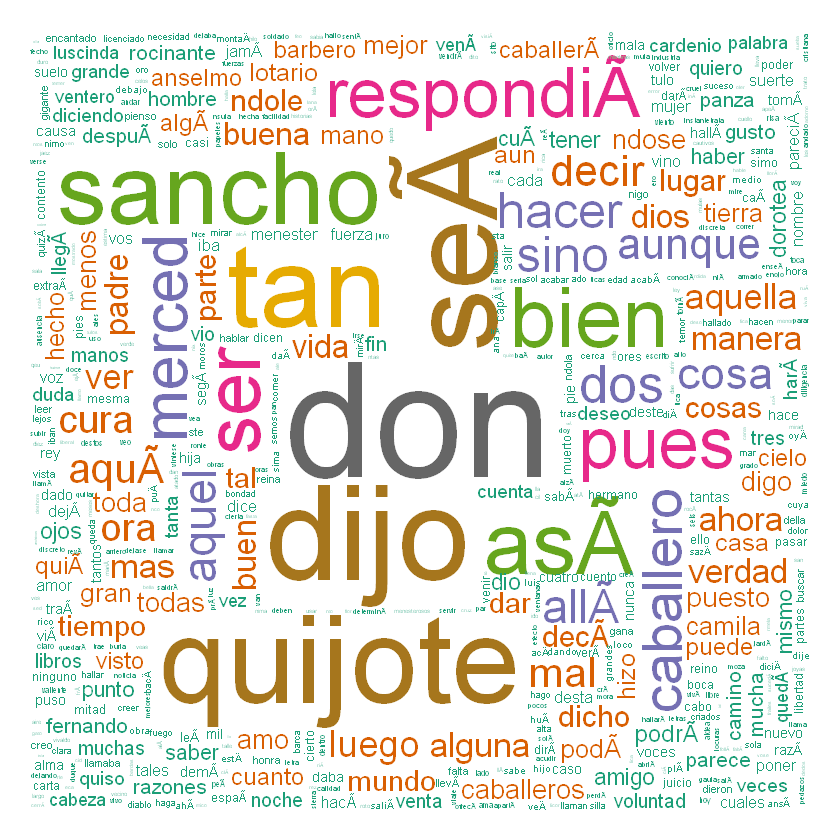

In [3]:
## Se grafica la nube de palabras
wordcloud(term.d$word,term.d$freq, scale=c(8,.2),min.freq=3, max.words=Inf, random.order=FALSE, rot.per=.15, colors=brewer.pal(8,"Dark2"))

In [4]:
#Carga de palabras positivas
palabras.positivas <-read.csv("fuenteDatos/Palabras-Positivas.csv",stringsAsFactors = F)
palabras.positivas <- as.vector(palabras.positivas[,1])
#Carga de palabras negativas
palabras.negativas <-read.csv("fuenteDatos/Palabras-Negativas.csv",stringsAsFactors = F)
palabras.negativas <- as.vector(palabras.negativas[,1])

texto=unlist(strsplit(quijote, " ", fixed = TRUE))

In [5]:
limpiar.respuestas <- function(respuesta){
    # Eliminar los links
    texto <- respuesta
    texto <- str_replace_all(texto,"(f|ht)(tp)(s?)(://)(.*)[.|/](.*)", " ")
    # Elimina la referencia a un retuit
    texto <- str_replace_all(texto,"(RT|via)((?:\\b\\W*@\\w+)+)", " ")
    # Elimina los #hashtag
    texto <- str_replace_all(texto,"#\\w+", " ")
    # Elimina la referencia a @usuarios
    texto <- str_replace_all(texto,"@\\w+", " ")
    # Elimina los signos de puntuacién
    texto <- str_replace_all(texto,"[[:punct:]]", " ")
    # Elimina los numeros
    texto <- str_replace_all(texto,"[[:digit:]]", " ")
    # Elimina espacios innecesarios
    texto <- str_replace_all(texto,"[ \t]{2,}", " ")
    texto <- str_replace_all(texto,"^\\s+|\\s+$", "")
    texto <- str_replace_all(texto,"\\n", "")
    # Retorna el texto limpio
    list(texto =texto)
}

In [6]:
texto.limpio <- lapply(texto,limpiar.respuestas)

In [7]:
extraer.puntaje <- function(respuestas, palabras.positivas,palabras.negativas) {
  # Inicio de la función    
  puntajes <-  lapply(respuestas,
  function(respuestas, palabras.positivas, palabras.negativas) {
    # Extraemos el texto del tuit
    texto <- respuestas
    # Separamos el texto en palabras independientes
    palabras = unlist(str_split(texto, '\\s+'))
    # Conteo de palabras positivas
    positivos = !is.na(match(palabras, palabras.positivas))
    # Conteo de palabras negativas
    negativos = !is.na(match(palabras, palabras.negativas))
    # Diferencia entre palabras positivas y negativas
    puntaje = sum(positivos) - sum(negativos)
    # Se retorna el texto,puntaje y la fecha de publicación
    return(list(texto = respuestas,calificacion = puntaje))
  }, palabras.positivas, palabras.negativas)
  # Se convierte a un data.frame y se da formato a las columnas.
  salida <- data.frame(matrix(unlist(puntajes),ncol = 2,byrow = T),stringsAsFactors = F)
  colnames(salida) <- c("texto","puntaje")
  salida["puntaje"] <- as.integer(salida[,2])
  return(salida)
  # Fin de la función
}

In [8]:
caso1<- extraer.puntaje(texto.limpio ,palabras.positivas,palabras.negativas)

In [9]:
### Sentimientos en Quijote
print(table(caso1$puntaje))


    -1      0      1 
  6000 176702   4600 


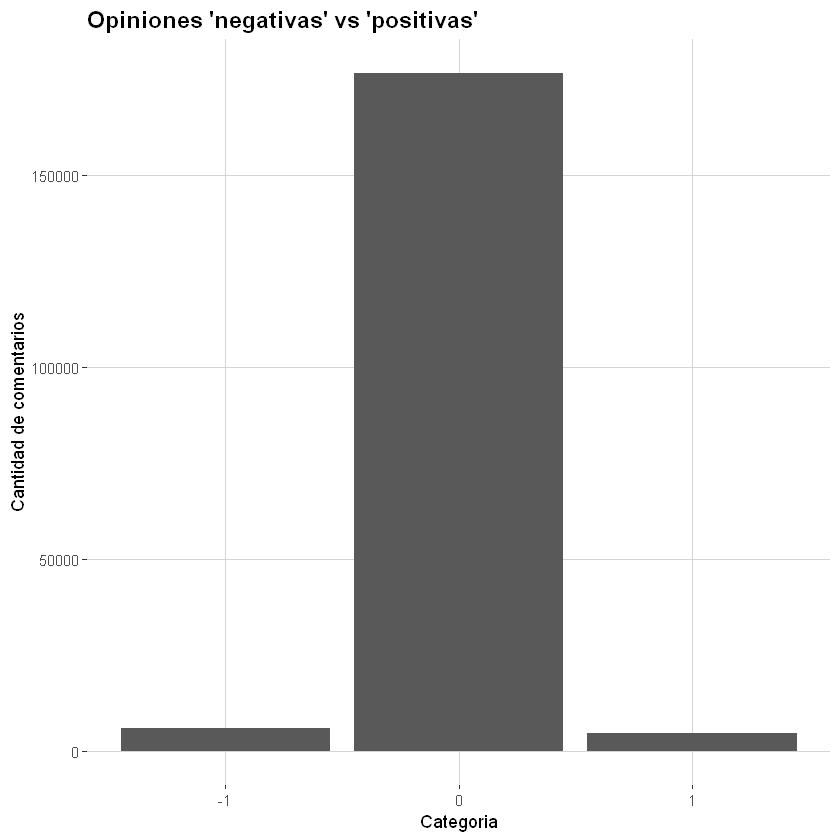

In [10]:
g <- ggplot(caso1,aes(caso1$puntaje,fill=caso1$puntaje))+ geom_bar()
g + theme(panel.grid.major = element_line(colour = "gray83"), 
    plot.title = element_text(size = 14, face = "bold"), 
    panel.background = element_rect(fill = "gray100")) +
    labs(title = "Opiniones 'negativas' vs 'positivas' ", 
    x = "Categoria", y = "Cantidad de comentarios", 
    fill = "Categorias")

# Conlusión
El modelo de análisis es funcional, pero, está bajo el uso de los diccionarios de la palabras positivas y negativas.
No debería usarse sin alimentar los diccionarios.